# Define all imports

In [1]:
import string
import nltk
from nltk import word_tokenize, FreqDist, tokenize
from nltk.corpus import stopwords
from xlrd import open_workbook
import re

import wordcloud
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import pandas as pd

import enchant
d = enchant.Dict("en_US")
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize

In [2]:
newstopwords=stopwords.words("English")
newstopwords=newstopwords+['january','february','march','april','may','june','july','august','september','october','november','december']
newstopwords=newstopwords+['employee','employer','company','approximately','work','right','leave','worker','coworker','catch','back']
newstopwords=newstopwords+['one','two','three','four','five','six','number']
newstopwords=newstopwords+['kill','hospitalization','heart','attack','finger','foot','abdomen','hand','injure','injury','amputate','head','fracture','suffer','cause','treat','treatment','hospital','hospitalize']
newstopwords=newstopwords+['investigation','coworkers','inside','another','area','place','onto','accident','become','part','line','side','break','pull','build','central','inside','time']
WNlemma = nltk.WordNetLemmatizer()

def pre_process(text):
    text=str(text)
    #print(len(text))
    #if not text.isdigit():
    tokens=nltk.word_tokenize(text)
        #print(tokens)
    tokens=[ t.lower() for t in tokens if t not in string.punctuation ]
    tokens=[ WNlemma.lemmatize(t.lower(),pos='v') for t in tokens]
    tokens=[ WNlemma.lemmatize(t.lower(),pos='n') for t in tokens]
    tokens=[ t for t in tokens if t not in newstopwords]
    tokens = [ t for t in tokens if len(t) > 3 ]
    tokens = [word1 for word1 in tokens if not re.search(r'\b\w*\d+\W*\b', word1)] #remove words with digits
    tokens = [word2 for word2 in tokens if not re.search(r'\w*\.+', word2)] #remove words with full stop
    tokens = [word3 for word3 in tokens if d.check(word3)] #remove none english word
    try:
        #print(tokens)
        tokens = [word4[0] for word4 in nltk.pos_tag(tokens) if word4[1]!='VB' ] #get none verb
        #print(tokens)
        text_after_process=" ".join(tokens)
    except:
        print('not working')
        text_after_process=tokens
    return(text_after_process)

def get_freq(text):    
    test=''
    for sublist in text: 
        test=test + ' ' + sublist
    words = nltk.tokenize.word_tokenize(test)
    fdist = FreqDist(words)
    return fdist

def get_Bigram(text):    
    from nltk.corpus import stopwords
    from nltk.collocations import BigramCollocationFinder
    from nltk.metrics import BigramAssocMeasures
   
    test=''
    for sublist in text: 
        test=test + ' ' + sublist
    words = nltk.tokenize.word_tokenize(test)
    bcf = BigramCollocationFinder.from_words(words)
    for m in bcf.nbest(BigramAssocMeasures.likelihood_ratio, 50):
        bigram_result=print(nltk.tag.pos_tag(m))
    return bigram_result

def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = int(360.0 * 21.0 / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)

    return "hsl({}, {}%, {}%)".format(h, s, l)

def create_wordcloud(text,title): 
    # We can also generate directly from the frequency information
    wc2 = WordCloud(background_color="black",color_func = random_color_func)
    #wc2.recolor(color_func = grey_color_func)
    wc2.generate_from_frequencies(text)
    plt.imshow(wc2, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()
    
def get_occupation(text):
    text=str(text)
    sentence_tokenize = sent_tokenize(text)
    
    try:
        searchObj = re.search( r'\(*Employee\)* #1 a (\w+\s\w+\b)', sentence_tokenize[0], re.M|re.I) #extract occupation name
        tokens=nltk.word_tokenize(searchObj.group(1))
        post_tag=nltk.pos_tag(tokens)
        if post_tag[1][1] != 'VBD' and post_tag[1][1] != 'IN':
            #print(searchObj.group(1))
            return (searchObj.group(1))
        else:
            #print(post_tag[0][0])
            return(post_tag[0][0])
    except:
        pass

def get_action(text):
    text=str(text)
    sentence_tokenize = sent_tokenize(text.lower())

    try:
        searchObj = re.search( r'(was|were) (\D*\s*?)', sentence_tokenize[0], re.M|re.I) #extract occupation name
        
        #lemmatize
        tokens=nltk.word_tokenize(searchObj.group(2))
        tokens=[ t.lower() for t in tokens if t not in string.punctuation ]
        tokens=[ WNlemma.lemmatize(t,pos='v') for t in tokens]
        tokens=[ WNlemma.lemmatize(t,pos='n') for t in tokens]
        tokens=[ t for t in tokens if t not in newstopwords]
        #print(" ".join(tokens))
        return " ".join(tokens)
    except:
        return text.lower()
        #pass

# Arrange data in table form using Panda (4 columns from osha file with header as Index, Title, Decription, Support1 and Support2)

In [3]:
#news=pd.read_excel('osha.xlsx',header=None,names = ["Index", "Title","Description", "Support1","Support2"])
news=pd.read_csv('osha1.csv', index_col='Case')
news.head()

,Title,Description,Summary,Classification,Cause,Fatal
Case,,,,,,
201079928,Employee Is Burned By Forklift Radiator Fluid,At approximately 11:30 a.m. on November 13 2...,burn industrial truck waste proc fac pa...,,Exposure to extreme temperatures,False
202561825,Employee Falls From Flatbed Trailer And Later...,On August 30 2013 Employee #1 was working f...,truck flatbed truck trailer fall abdomen,,Struck By Moving Objects,True
200361855,Two Workers Are Struck By Motor Vehicle And O...,On August 27 2013 Employees #1 and #2 of T...,construction undrgrd power line highway ...,1 317290559 Fatality Other Occupation not re...,Struck By Moving Objects,True
200361863,Employee Is Struck By Bales Of Wire And Killed,On August 26 2013 Employee #1 with Lee Iro...,waste proc fac industrial truck struck b...,,Struck By Moving Objects,True
201079324,Employee Is Splashed With Hot Water And Is Bu...,On July 14 2013 Employee #1 vacuum pump tr...,truck driver pump tank hot water struc...,,Exposure to extreme temperatures,False


# list down most frequent key words after removing words none related to occupation

In [4]:
# Apply preprocessing to every document in the training set.
decribe = news['Description']
toks_des = decribe.apply(pre_process)

support1 = news['Summary']
toks_support = support1.apply(pre_process)

title = news['Title']
toks_title = title.apply(pre_process)

Causes = news['Cause']

In [5]:
Description_dist=get_freq(toks_des)
title_dist=get_freq(toks_title)
support1_dist=get_freq(toks_support)

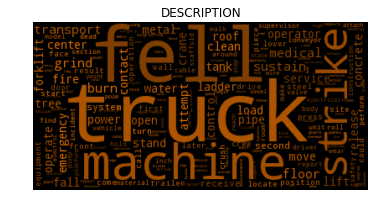

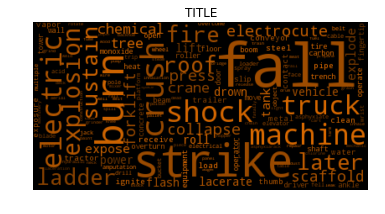

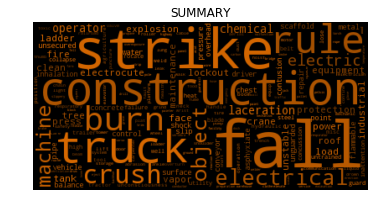

In [6]:
create_wordcloud(Description_dist,"DESCRIPTION")
create_wordcloud(title_dist,"TITLE")
create_wordcloud(support1_dist,"SUMMARY")

In [7]:
#comment
#1) Fall and fell words appear most frequent among the 3 columns. 
#2) Construction also appear frequently under description. Together with fall and fell suggesting construction related occupation maybe be the frequent contribution to accident
#3) Truck also appear frequently under description column. Likely this is related to heavy vehicle driver occupation


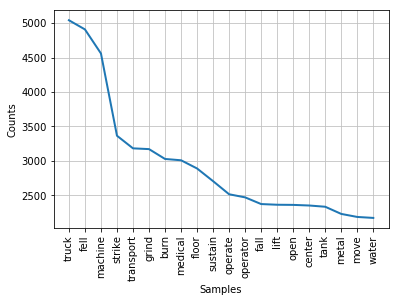

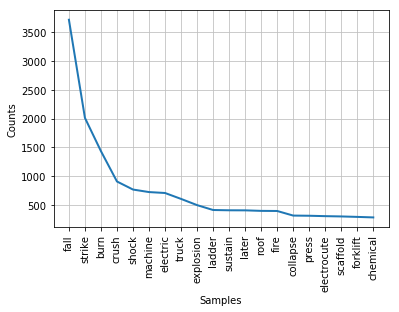

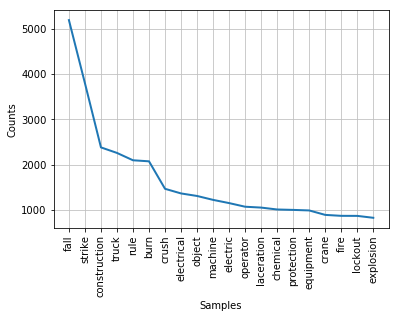

In [8]:
Description_distplot=Description_dist.plot(20)
Title_distplot=title_dist.plot(20)
Support1_distplot=support1_dist.plot(20)

In [9]:
#comments:
#1) fell and fall appear most frequent which related to construction activity
#2) truck also appear most frequent which related to heavy vehicle driver

# Possible list of occupation or work under Description column

In [10]:
likely_occupation = news['Description']
#likelyoccup_des = likely_occupation.apply(get_occupation) #extract words (max 2) right after Employee #1
#possible list of name
count=0
for m in likely_occupation:
    #print(str(count)+":"+str(get_occupation(m)))
    count=count+1

# Extract phrases likely related to work in description column

In [11]:
decribe = news['Description']
toks_des_action = decribe.apply(get_action) # words right after was or were which describe what the person doing at that point in time
toks_des_occupation = decribe.apply(get_occupation)

# Categories Occupations based on extracting keywords from each case

In [12]:
#the worker title based on heuristic info
occupation_dict=dict({
            'carpenter':['wood','carpentry','carpenter'],
            'chemical worker':['chemical','anhydrous ammonia','oxy-acetylene','container','tank','xylene','burn','acid','acetone'],
            'construction worker':['catwalk','scaffold','safety bar','construct','aerial lift','scissor lift','chimney','tile','ceiling','demolition','pallet','foreman','construction','ladder','contractor','roof','concrete','fell','fall','cement'],
            'electrician':['wire','circuit','electrocute','electric','electronic','power','transformer','volt'],
            'firefighter':['fire','blaze'],        
            'hotel/restaurant worker':['motel','hotel','restaurant'],
            'hospital worker':['medicine','medical'],
            'heavy vehicle driver':['excavator','truck','forklift','tractor','trailer','crane'],
            'light vehicle driver':['vehicle'],
            'machine operator':['machine','tire','vibrator','conveyor','crusher','grind'],
            'shop/office worker':['computer','shop','office','supermarket','receptionist','casher','desk'],
            'wood logger':['yarder','tree','logging'],
            'mower':['grass'],
            'dock worker':['loader','load','terminal','hoist'],
            'painting service':['paint','painting'],
            'cleaner':['wash','sewer tank','odorous','vacuum','tank','water','clean','sanitize'],
            'technician':['equipment','machinery','technician'],
            'mechanic':['maintenance','mechanical'],
            'derrickman':['pipe','drill'],
            'digger':['excavation'],
            'farmer':['agriculture','vineyard','cow','harvest','barn','coccidioides imitis fungus','crop market','peach','fruit','farmer','farm','blackberries','harverst','grape','picker','gardern'],
            'sales worker':['cash','retail','store'],
            'well puller':['oil'],
            'welder':['welding','vapor','gas'],
            'clerk':['clerk','stockroom'],
            'food worker':['food'],
            'road worker':['highway','road','traffic'],
            'blasting worker':['blast'],
            'operator':['operator','production','operating','operation','operate','manufacture','assemble'],
            'laborer':['laborer','labor'],
            'welder':['weld','torch'],
            'hoister':['hoist'],
            'grinder':['grind'],
            'warehouse':['warehouse','storage'],
            'hydraulic pneumatic worker':['gas','hydraulic','pressure','compress','pneumatic','air hammer','pressurize'],
            'fisherman':['sea urchin'],
            'engineer':['engineer'],
            'instructor':['program','instructor'],
            'amusement park worker':['amusement','park'],
            'inmate':['inmate'],
            'machine cutter':['saw','chopper'],
            'trash collector':['trash'],
            'plumber':['hose','plumb','pump'],
            'aerospace':['aircraft','aerospace','airline','airplane','aeroplane','helicopter'],
            'animal worker':['wildlife','feed','zoo','keeper','animal','horse'],
            'police':['police'],
            'telecom':['antenna','phone','cell','cellular','communication','tower'],
            'restoration service':['asbestos'],
            'contractor':['repair','residential','renovation','residence'],
            'nature lifeguard':['storm','hurricane','avalanche','snow','snowmobile'],
            'logistic':['rigger','rig','transport','airport'],
            'factory worker':['factory','industry'],
            'installer':['instal','beam','steel'],
            'guard':['security','guard'],
            'cable guy':['cable'],
            'inspector':['inspection','inspect','inspector'],
            'service guy':['service'],
            'supervisor':['supervisor','supervise']
        })

# Getting the occurance of the occupation based on how frequent each of the keywords appear on each cases

In [13]:
count=np.zeros((len(occupation_dict)), dtype=np.int)
Ind_count=np.zeros((len(occupation_dict)), dtype=np.int)
found_flag=False
track_missing=[]
store_occupation_array=[]
#print(toks_des_action)
line_tracking=0
for num in toks_des_action: #screen thru each cases
#for num in news['Description']:
    #reset for each case
    found_flag=False
    Ind_count=np.zeros((len(occupation_dict)), dtype=np.int)
    tracking=0 #occupation index. Reset for each looping of case
    #print(num)
    if num!=None:
        for key,value in occupation_dict.items():
            #print(key)
            for v in value:
                #print(v)
                if num.find(v)>=0: #detected matching. Update the count
                    found_flag=True
                    Ind_count[tracking]=Ind_count[tracking]+1
            tracking=tracking+1
        
        if found_flag==True: #only update the occupation after obtaining highest freq in occupation dist for each cases
            #find out which occupation has the highest score
            max_value = max(Ind_count)
            #print(Ind_count)
            #print(max_value)
            max_index = Ind_count.tolist().index(max_value)
            #print(max_index)
            count[max_index]=count[max_index]+1
            store_occupation_array.append(list(occupation_dict)[max_index])
            #print(list(occupation_dict)[max_index])
        else:
            track_missing.append(num)
            store_occupation_array.append('')
    else:
        track_missing.append(num)
        store_occupation_array.append('')
            
    line_tracking=line_tracking+1
    #print(line_tracking)
len(track_missing)
print("Total number of cases " + str(len(store_occupation_array)))
#print(count)
#len(store_occupation_array)

Total number of cases 16323


# Redo on entire description column

In [14]:
break_flag=False
empty_flag=False
found_flag=False
track_missing=[]
Ind_count=np.zeros((len(occupation_dict)), dtype=np.int)

line_tracking=0
for num in news['Description']: #screen thru each cases
    
    #reset for each case
    found_flag=False
    Ind_count=np.zeros((len(occupation_dict)), dtype=np.int)
    tracking=0 #occupation index. Reset for each looping of case
    #print(num)
    if num!=None:
        for key,value in occupation_dict.items():

            for v in value:
                #print(v)
                if num.find(v)>=0: #detected matching. Update the count and move to next case
                    if store_occupation_array[line_tracking]=="": #empty go ahead to update occupation
                        found_flag=True
                        Ind_count[tracking]=Ind_count[tracking]+1
            tracking=tracking+1
            
        if found_flag==True:
            #find out which occupation has the highest score
            max_value = max(Ind_count)
            #print(Ind_count)
            #print(max_value)
            max_index = Ind_count.tolist().index(max_value)
            #print(max_index)
            count[max_index]=count[max_index]+1
            store_occupation_array[line_tracking]=list(occupation_dict)[max_index]
            #print(list(occupation_dict)[max_index])
        
    if store_occupation_array[line_tracking]=="":
        track_missing.append(num) #track how many cases without occupation identificatinon
        #store_occupation_array.append('')
    line_tracking=line_tracking+1
print("cases unable to identify occupation " + str(len(track_missing))) 
#print(len(store_occupation_array))

cases unable to identify occupation 334


# Redo Occupation identification on Support1 column to try to fill up cases without occupation

In [15]:
break_flag=False
empty_flag=False
found_flag=False
track_missing=[]
Ind_count=np.zeros((len(occupation_dict)), dtype=np.int)

line_tracking=0
for num in news["Summary"]: #screen thru each cases
    
    #reset for each case
    found_flag=False
    Ind_count=np.zeros((len(occupation_dict)), dtype=np.int)
    tracking=0 #occupation index. Reset for each looping of case
    #print(num)
    if num!=None:
        for key,value in occupation_dict.items():

            for v in value:
                #print(v)
                if num.find(v)>=0: #detected matching. Update the count and move to next case
                    if store_occupation_array[line_tracking]=="": #empty go ahead to update occupation
                        found_flag=True
                        Ind_count[tracking]=Ind_count[tracking]+1
            tracking=tracking+1
            
        if found_flag==True:
            #find out which occupation has the highest score
            max_value = max(Ind_count)
            #print(Ind_count)
            #print(max_value)
            max_index = Ind_count.tolist().index(max_value)
            #print(max_index)
            count[max_index]=count[max_index]+1
            store_occupation_array[line_tracking]=list(occupation_dict)[max_index]
            #print(list(occupation_dict)[max_index])
        
    if store_occupation_array[line_tracking]=="":
        track_missing.append(num) #track how many cases without occupation identificatinon
        #store_occupation_array.append('')
    line_tracking=line_tracking+1
print("cases unable to identify occupation " + str(len(track_missing))) 
#print(len(store_occupation_array))

cases unable to identify occupation 132


# Hit count for each occupation categories

In [16]:
print(count) #frequency for each occupation

[ 371 1172 3636 1074  211   67  133 1614  113 1141  156  230   17  402  111
  831  143  142  262   30  240  106  144  113    4   34  162   26  931  134
    0    0   95  248    5   12   12   67    6   87   15   87   35   70    9
  112   11  225   25  343   13  372   43   25  445   61   18]


# Overall distribution of occupation for 16323 cases

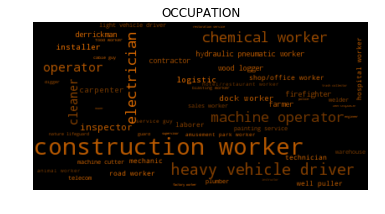

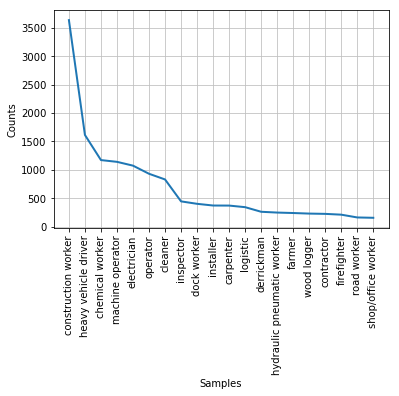

In [17]:
combine=[]
track=0
for key,value in occupation_dict.items():
    #print(key)
    #print(count[track])
    for i in range (0,count[track]-1):
        combine.append(key)
    track=track+1

Occupation_dist = FreqDist(combine)
create_wordcloud(Occupation_dist,"OCCUPATION")
Occupation_distplot=Occupation_dist.plot(20)

In [18]:
#comments
#1) Construction related work recorded the highest accident
#2) The 2nd highest is the heavy vehicle driver

# Segregation of occupation based on causes

In [19]:
#segregate based on causes. 12 causes in total
cause1=[] #Struck By Moving Objects
cause2=[] #Caught in/between Objects
cause3=[] #Falls
cause4=[] #Fires and Explosion
cause5=[] #Electrocution
cause6=[] #Exposure to extreme temperatures
cause7=[] #Suffocation
cause8=[] #Drowning
cause9=[] #Exposure to Chemical Substances
cause10=[] #Collapse of object
cause11=[] #Other
cause12=[] #Others

indexs=0

for m in Causes:
    if m.find('Struck By Moving Objects')>=0:
        cause1.append(store_occupation_array[indexs])
    elif m.find('Caught in/between Objects')>=0:
        cause2.append(store_occupation_array[indexs])
    elif m.find('Falls')>=0:
        cause3.append(store_occupation_array[indexs])
    elif m.find('Fires and Explosion')>=0:
        cause4.append(store_occupation_array[indexs])
    elif m.find('Electrocution')>=0:
        cause5.append(store_occupation_array[indexs])
    elif m.find('Exposure to extreme temperatures')>=0:
        cause6.append(store_occupation_array[indexs])
    elif m.find('Suffocation')>=0:
        cause7.append(store_occupation_array[indexs])
    elif m.find('Drowning')>=0:
        cause8.append(store_occupation_array[indexs])
    elif m.find('Exposure to Chemical Substances')>=0:
        cause9.append(store_occupation_array[indexs])
    elif m.find('Collapse of object')>=0:
        cause10.append(store_occupation_array[indexs])
    elif m.find('Other')>=0 or m.find('Others')>=0:
        cause11.append(store_occupation_array[indexs])
    #elif m.find('Others')>=0:
        #cause12.append(store_occupation_array[indexs])
    indexs=indexs+1
    #print (indexs)
#print(len(cause1))

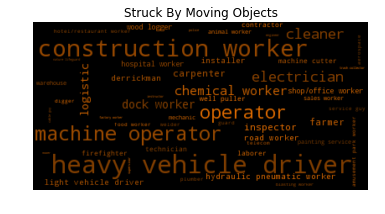

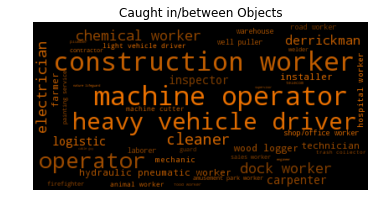

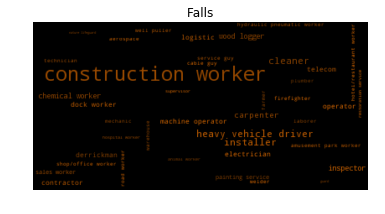

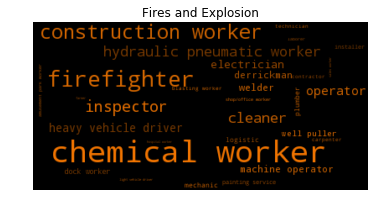

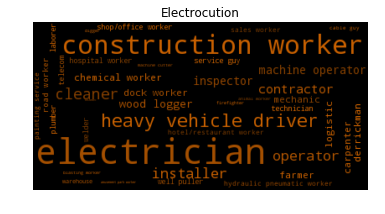

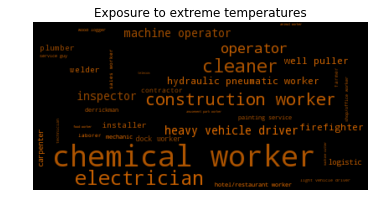

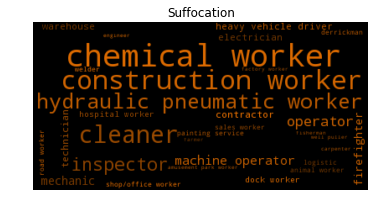

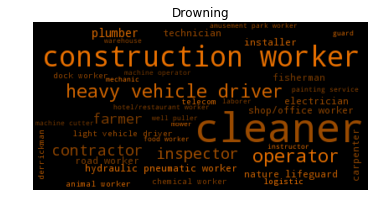

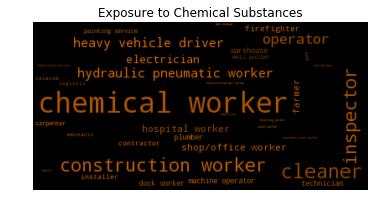

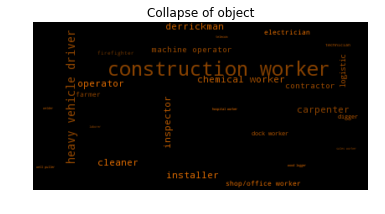

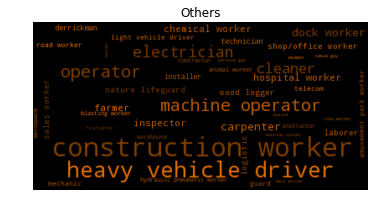

In [20]:
try: 
    Occupation_dist1 = FreqDist(cause1) 
    create_wordcloud(Occupation_dist1,"Struck By Moving Objects") 
    #Occupation_distplot=Occupation_dist1.plot(20)
    
    Occupation_dist2 = FreqDist(cause2)
    create_wordcloud(Occupation_dist2,"Caught in/between Objects")

    Occupation_dist3 = FreqDist(cause3)
    create_wordcloud(Occupation_dist3,"Falls")

    Occupation_dist4 = FreqDist(cause4)
    create_wordcloud(Occupation_dist4,"Fires and Explosion")

    Occupation_dist5 = FreqDist(cause5)
    create_wordcloud(Occupation_dist5,"Electrocution")

    Occupation_dist6 = FreqDist(cause6)
    create_wordcloud(Occupation_dist6,"Exposure to extreme temperatures")

    Occupation_dist7 = FreqDist(cause7)
    create_wordcloud(Occupation_dist7,"Suffocation")

    Occupation_dist8 = FreqDist(cause8)
    create_wordcloud(Occupation_dist8,"Drowning")

    Occupation_dist9 = FreqDist(cause9)
    create_wordcloud(Occupation_dist9,"Exposure to Chemical Substances")

    Occupation_dist10 = FreqDist(cause10)
    create_wordcloud(Occupation_dist10,"Collapse of object")

    Occupation_dist11 = FreqDist(cause11)
    create_wordcloud(Occupation_dist11,"Others")
except: pass

In [21]:
#Summarises
#1) Contruction related work appeared significantly on almost all the causes of accident which tally to initial 
#   observation.
#2) Occupation tally quite well with the causes of accident. Example struck by moving object is related to 
#   heavy vehicle driver occupation and fall is related to construction related work.

# Save to Osha1_added_Occupation.xls file with added occupation column

In [ ]:
from pandas import ExcelWriter
#df1 = pd.DataFrame({'Case':news['Case']})
df2 = pd.DataFrame({'Title':news['Title']})
df3 = pd.DataFrame({'Description':news['Description']})
df4 = pd.DataFrame({'Summary':news['Summary']})
df5 = pd.DataFrame({'Cause':news['Cause']})
df6 = pd.DataFrame({'Fatal':news['Fatal']})
df7 = pd.DataFrame({'Occupation':store_occupation_array})

writer = ExcelWriter('Osha1_added_Occupation.xlsx')
#df1.to_excel(writer,'out_title',index=False,startcol=0)
df2.to_excel(writer,'out_title',index=False,startcol=1)
df3.to_excel(writer,'out_title',index=False,startcol=2)
df4.to_excel(writer,'out_title',index=False,startcol=3)
df5.to_excel(writer,'out_title',index=False,startcol=4)
df6.to_excel(writer,'out_title',index=False,startcol=5)
df7.to_excel(writer,'out_title',index=False,startcol=6)
writer.save()

In [23]:
news['Occupation'] = store_occupation_array
news.head()

,Title,Description,Summary,Classification,Cause,Fatal,Occupation
Case,,,,,,,
201079928,Employee Is Burned By Forklift Radiator Fluid,At approximately 11:30 a.m. on November 13 2...,burn industrial truck waste proc fac pa...,,Exposure to extreme temperatures,False,heavy vehicle driver
202561825,Employee Falls From Flatbed Trailer And Later...,On August 30 2013 Employee #1 was working f...,truck flatbed truck trailer fall abdomen,,Struck By Moving Objects,True,heavy vehicle driver
200361855,Two Workers Are Struck By Motor Vehicle And O...,On August 27 2013 Employees #1 and #2 of T...,construction undrgrd power line highway ...,1 317290559 Fatality Other Occupation not re...,Struck By Moving Objects,True,road worker
200361863,Employee Is Struck By Bales Of Wire And Killed,On August 26 2013 Employee #1 with Lee Iro...,waste proc fac industrial truck struck b...,,Struck By Moving Objects,True,heavy vehicle driver
201079324,Employee Is Splashed With Hot Water And Is Bu...,On July 14 2013 Employee #1 vacuum pump tr...,truck driver pump tank hot water struc...,,Exposure to extreme temperatures,False,electrician


In [24]:
summary = news.groupby('Occupation').Occupation.count()

In [25]:
dfSummary = pd.DataFrame(summary)
dfSummary = dfSummary.rename(columns={'Occupation': 'Count'})
dfSummary.sort_values(by='Count', ascending=False, inplace=True)
total = dfSummary['Count'].sum()
dfSummary['Percentage'] = (dfSummary['Count']/total)*100
dfSummary.head()

,Count,Percentage
Occupation,,
construction worker,3636,22.275317
heavy vehicle driver,1614,9.887888
chemical worker,1172,7.180053
machine operator,1141,6.990137
electrician,1074,6.579673


In [26]:
dfSummary['Count'].sum()

16323

In [27]:
summary_occu = news.groupby(['Cause','Occupation']).Occupation.count()

In [28]:
dfSumm1 = pd.DataFrame(summary_occu['Struck By Moving Objects'].sort_values(ascending=False))
dfSumm1 = dfSumm1.rename(columns={'Occupation': 'Count'})
total = dfSumm1['Count'].sum()
dfSumm1['Percentage'] = (dfSumm1['Count']/total)*100
dfSumm1.head()

,Count,Percentage
Occupation,,
heavy vehicle driver,988,16.041565
construction worker,851,13.817178
machine operator,637,10.342588
operator,463,7.517454
cleaner,266,4.318883


In [29]:
dfSumm2 = pd.DataFrame(summary_occu['Falls'].sort_values(ascending=False))
dfSumm2 = dfSumm2.rename(columns={'Occupation': 'Count'})
total = dfSumm2['Count'].sum()
dfSumm2['Percentage'] = (dfSumm2['Count']/total)*100
dfSumm2.head()

,Count,Percentage
Occupation,,
construction worker,1720,51.713770
heavy vehicle driver,148,4.449790
installer,140,4.209260
cleaner,116,3.487673
carpenter,99,2.976548


In [30]:
dfSumm3 = pd.DataFrame(summary_occu['Caught in/between Objects'].sort_values(ascending=False))
dfSumm3 = dfSumm3.rename(columns={'Occupation': 'Count'})
total = dfSumm3['Count'].sum()
dfSumm3['Percentage'] = (dfSumm3['Count']/total)*100
dfSumm3.head()

,Count,Percentage
Occupation,,
construction worker,326,16.573462
machine operator,302,15.353330
heavy vehicle driver,247,12.557194
operator,214,10.879512
cleaner,97,4.931368
